In [17]:
import pandas as pd
import pickle
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
from constants import *

In [18]:
eco_df = pd.read_csv("data/ECO_codes.csv")
eco_dict = dict(zip(eco_df["code"], eco_df["name"]))
ECO_MAPPING_REVERSED = {v: k for k, v in ECO_MAPPING.items()}

FILENAME = "lichess_BabaGata_2025-02-02_1900.pkl"
file_path = os.path.join(MY_DIR, "predictions", FILENAME)
df = pd.read_pickle(file_path)

In [21]:
def analyze_openings(df, player_color):
    df_filtered = df[df["player_color"] == player_color]
    
    # Filter wins and losses based on player color
    wins = df_filtered[df_filtered["result"] == "1-0"] if player_color == "white" else df_filtered[df_filtered["result"] == "0-1"]
    losses = df_filtered[df_filtered["result"] == "0-1"] if player_color == "white" else df_filtered[df_filtered["result"] == "1-0"]
    
    # Count openings
    best_openings = Counter(wins["predicted_eco"]).most_common(5)
    worst_openings = Counter(losses["predicted_eco"]).most_common(5)
    
    # Calculate win-to-loss ratio
    win_loss_ratio = {}
    eco_list = df_filtered["predicted_eco"].unique()
    for eco in eco_list:
        wins_count = len(wins[wins["predicted_eco"] == eco])
        losses_count = len(losses[losses["predicted_eco"] == eco])
        win_loss_ratio[eco] = wins_count / (losses_count + 1)  # Avoid division by zero
    
    return best_openings, worst_openings, win_loss_ratio

def plot_openings(openings, title, filename):
    eco_codes = [ECO_MAPPING_REVERSED[eco] for eco, _ in openings]
    opening_names = [eco_dict.get(eco, eco) for eco in eco_codes]
    counts = [count for _, count in openings]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.barplot(x=eco_codes, y=counts, palette="viridis", ax=ax)
    ax.set_xticklabels([f"{eco}\n{name}" for eco, name in zip(eco_codes, opening_names)], rotation=45, ha="right")
    ax.set_xlabel("Opening (ECO Code)")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    plt.subplots_adjust(bottom=0.3)
    
    # Log figure to MLflow
    mlflow.log_figure(fig, filename)

def plot_win_loss_ratio(ratios, title, filename):
    eco_codes = [ECO_MAPPING_REVERSED[eco] for eco in ratios.keys()]
    opening_names = [eco_dict.get(eco, eco) for eco in eco_codes]
    win_loss_ratios = [ratios[eco] for eco in ratios.keys()]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.barplot(x=eco_codes, y=win_loss_ratios, palette="magma", ax=ax)
    # ax.set_xticklabels([f"{eco}\n{name}" for eco, name in zip(eco_codes, opening_names)], rotation=45, ha="right")
    ax.set_xlabel("Opening (ECO Code)")
    ax.set_ylabel("Win/Loss Ratio")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Log figure to MLflow
    mlflow.log_figure(fig, filename)

Best Openings as White: [(121, 15), (99, 8), (241, 7), (117, 7), (199, 5)]
Worst Openings as White: [(99, 14), (121, 11), (100, 8), (119, 7), (199, 7)]
Best Openings as Black: [(319, 14), (299, 10), (241, 10), (246, 9), (249, 6)]
Worst Openings as Black: [(319, 34), (241, 15), (299, 13), (249, 8), (301, 7)]


C:\Users\vujic\AppData\Local\Temp\ipykernel_21788\1907265203.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eco_codes, y=counts, palette="viridis", ax=ax)
C:\Users\vujic\AppData\Local\Temp\ipykernel_21788\1907265203.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{eco}\n{name}" for eco, name in zip(eco_codes, opening_names)], rotation=45, ha="right")
C:\Users\vujic\AppData\Local\Temp\ipykernel_21788\1907265203.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eco_codes, y=counts, palette="viridis", ax=ax)
C:\Users\vujic\AppData\Local\Temp\ipykernel_21788\1907265203.py

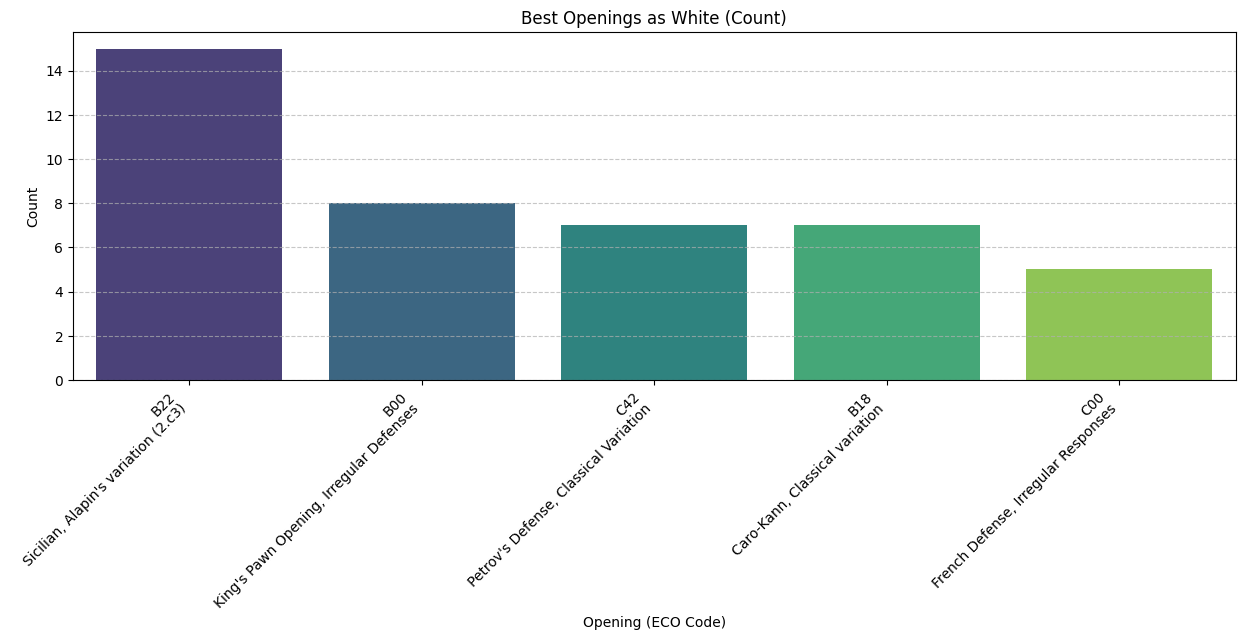

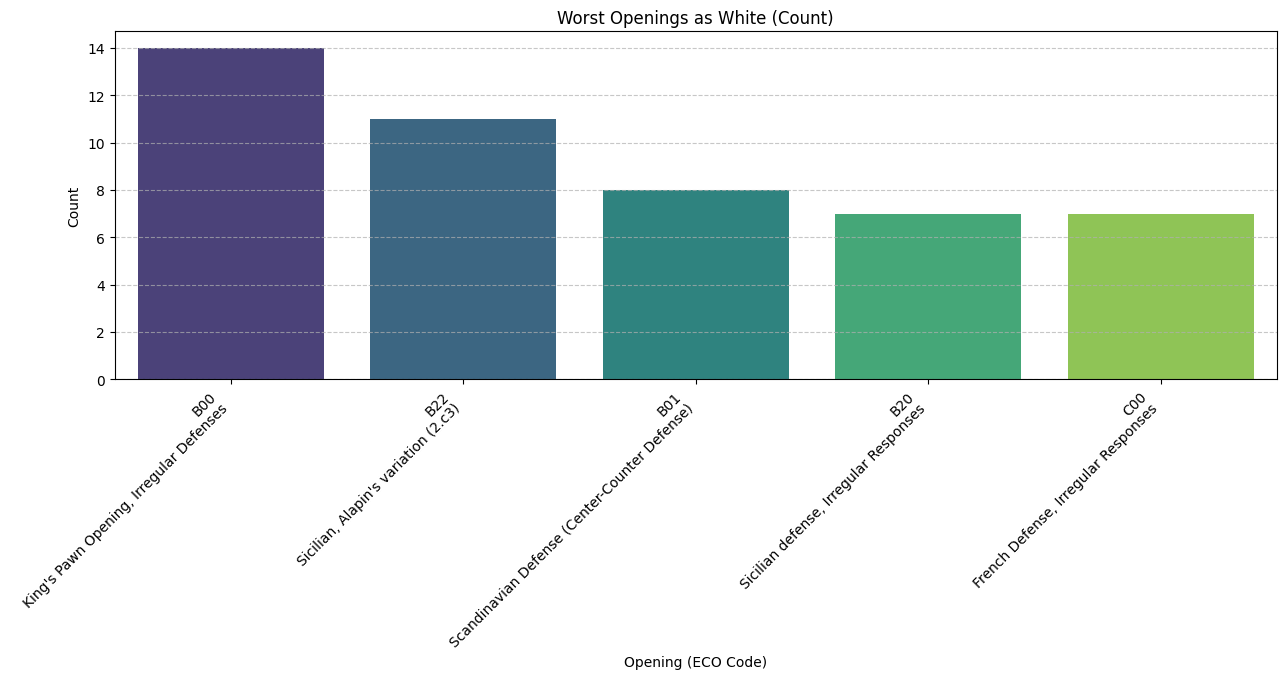

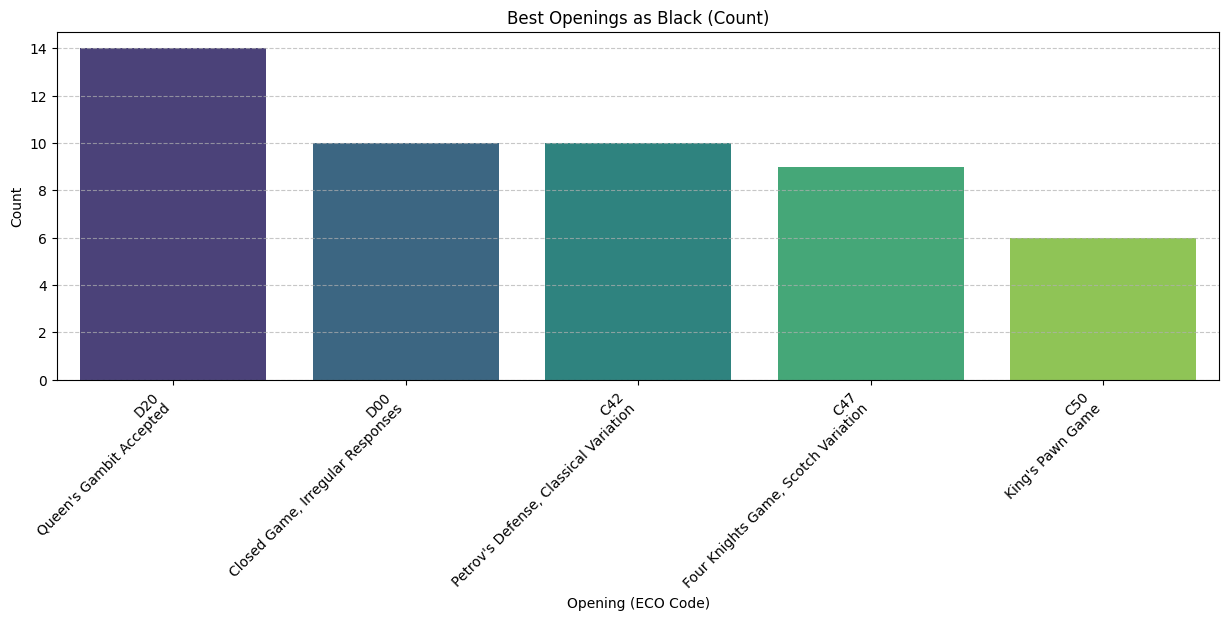

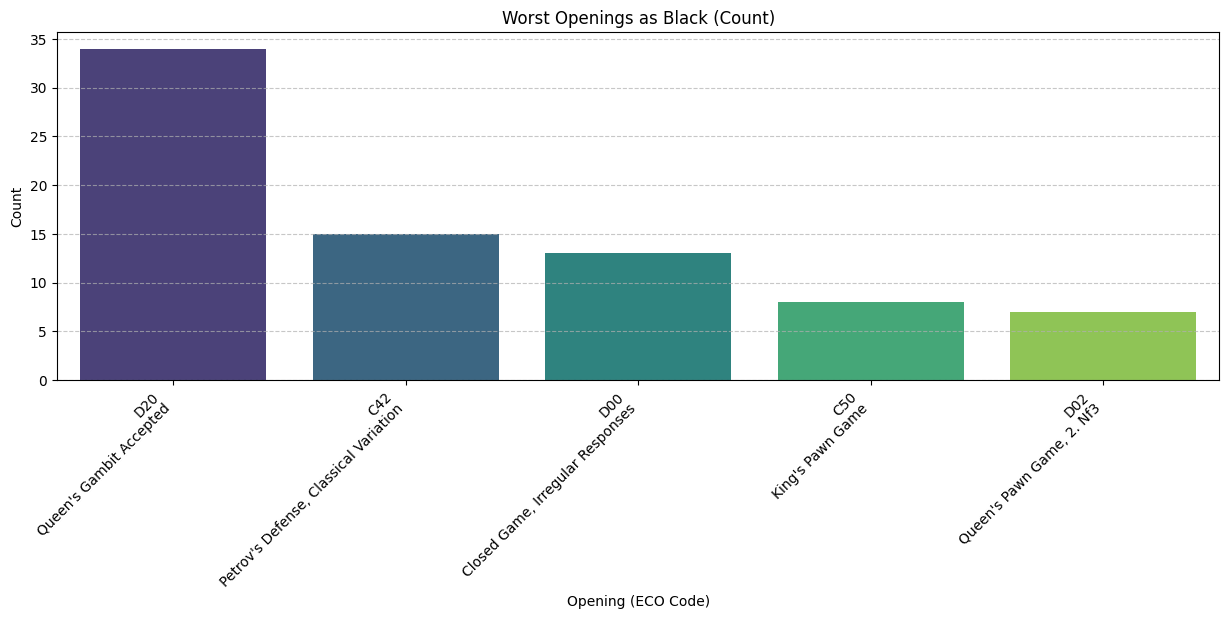

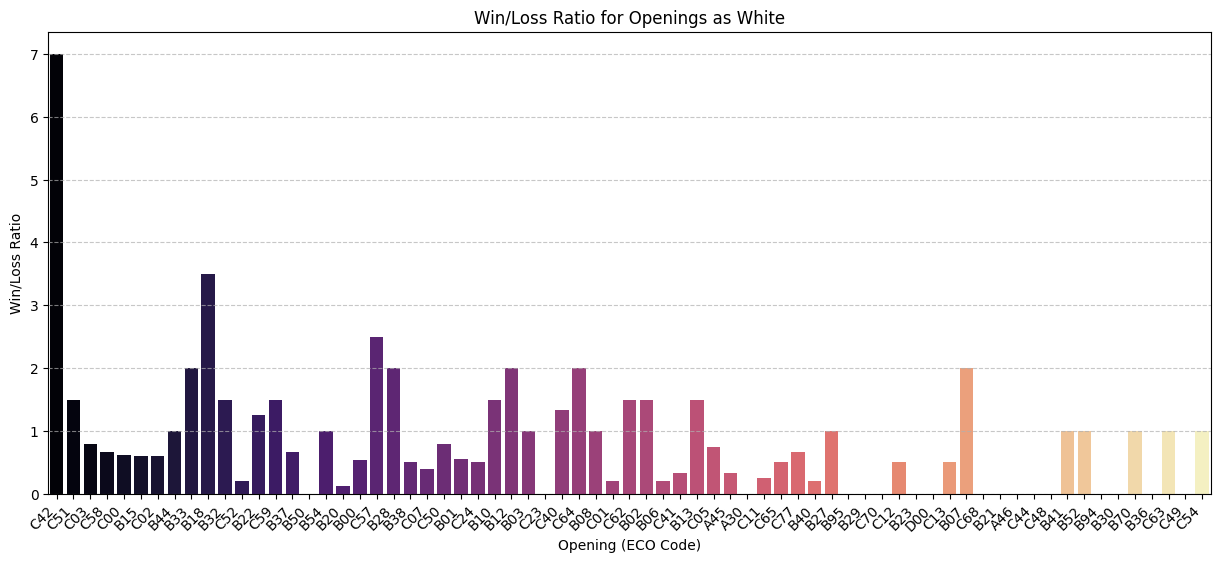

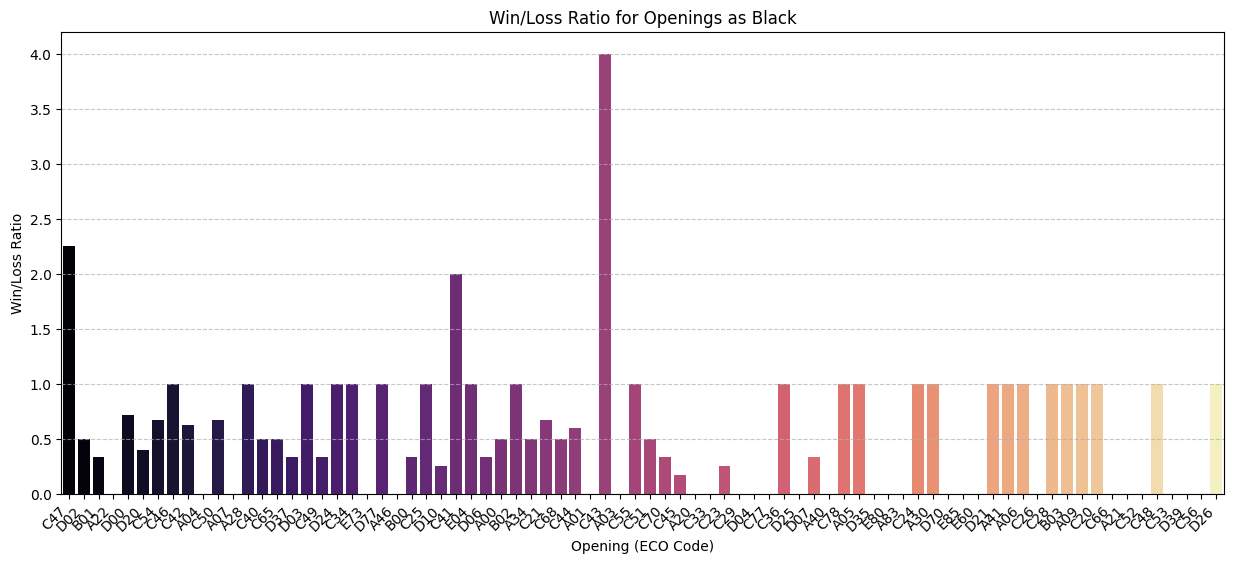

In [ ]:
# Analyze for white and black
best_white, worst_white, win_loss_white = analyze_openings(df, "white")
best_black, worst_black, win_loss_black = analyze_openings(df, "black")

# Display results
print("Best Openings as White:", best_white)
print("Worst Openings as White:", worst_white)
print("Best Openings as Black:", best_black)
print("Worst Openings as Black:", worst_black)

# Start MLflow experiment
mlflow.set_experiment("Opening Predictions")
with mlflow.start_run():
    mlflow.log_param("filename", FILENAME)
    
    plot_openings(best_white, "Best Openings as White (Count)", "best_openings_white_count.png")
    plot_openings(worst_white, "Worst Openings as White (Count)", "worst_openings_white_count.png")
    plot_openings(best_black, "Best Openings as Black (Count)", "best_openings_black_count.png")
    plot_openings(worst_black, "Worst Openings as Black (Count)", "worst_openings_black_count.png")
    
    plot_win_loss_ratio(win_loss_white, "Win/Loss Ratio for Openings as White", "win_loss_white.png")
    plot_win_loss_ratio(win_loss_black, "Win/Loss Ratio for Openings as Black", "win_loss_black.png")